Alpaca vs Not Alpaca - Image Classification with fastai


In this project, we build and evaluate an image classification system using the fastai library.
The goal is to distinguish between images of alpacas and images that do not contain alpacas.

We explore a strong baseline using transfer learning and evaluate two common improvement techniques:
data augmentation and increased model depth.


Problem Definition

Task: Binary image classification  
Classes:
- alpaca
- not alpaca

Motivation:  
This task represents a common real-world binary visual classification problem,
where objects may appear in varied poses, backgrounds, and lighting conditions.

Challenges:
- Visually similar animals (e.g., llamas, camels)
- Small dataset size
- Risk of overfitting


Imports & Setup

In [65]:
from fastai.vision.all import *
from pathlib import Path
import matplotlib.pyplot as plt


set_seed(42, reproducible=True)


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 7
})



Dataset:

The dataset consists of two classes:
- Alpaca: 142 images
- Not Alpaca: 185 images

Images were collected from a public Kaggle dataset and organized into class-labeled folders.


In [67]:
path = Path(r"dataset")  
assert path.exists(), f"Dataset folder not found: {path.resolve()}"

classes = [p.name for p in path.iterdir() if p.is_dir()]
classes

for cls in sorted(path.iterdir()):
    if cls.is_dir():
        print(cls.name, len(get_image_files(cls)))

print("Total images:", len(get_image_files(path)))


alpaca 142
not alpaca 185
Total images: 327


Cleaning broken images

In [68]:
files = get_image_files(path)
failed = verify_images(files)

print("Broken images found:", len(failed))

for f in failed:
    f.unlink()


Broken images found: 0


Data Loading (fastai)


We create train/validation splits automatically (80/20) with a fixed seed for reproducibility.


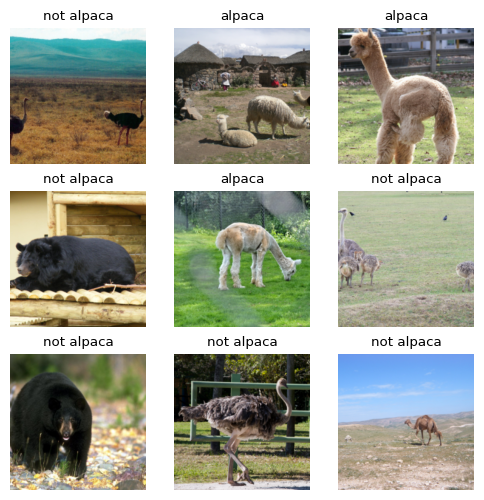

In [69]:
dls_base = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224)
)
dls_base.show_batch(max_n=9, figsize=(6,6))


## Baseline Model (ResNet34)


In [70]:
learn_base = vision_learner(dls_base, resnet34, metrics=accuracy)
learn_base.fine_tune(3, base_lr=3e-3)


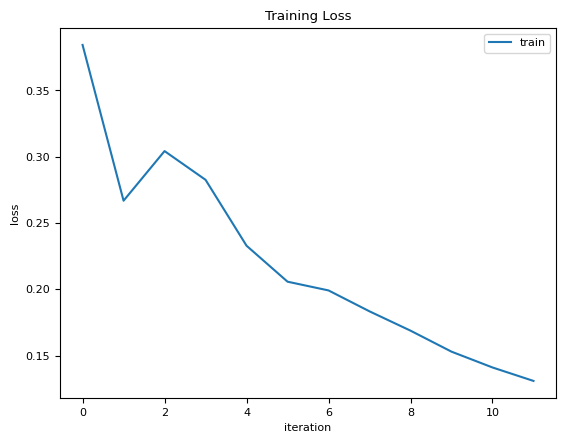

Final train_loss: 0.1308
Final valid_loss: 0.1866
Final accuracy:   0.9231


In [71]:

train_losses = [float(x) for x in learn_base.recorder.losses]

plt.figure()
plt.plot(train_losses, label="train")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training Loss")
plt.legend()
plt.show()

last = learn_base.recorder.values[-1]
train_loss_last, valid_loss_last, acc_last = last

print(f"Final train_loss: {train_loss_last:.4f}")
print(f"Final valid_loss: {valid_loss_last:.4f}")
print(f"Final accuracy:   {acc_last:.4f}")


Baseline evaluation


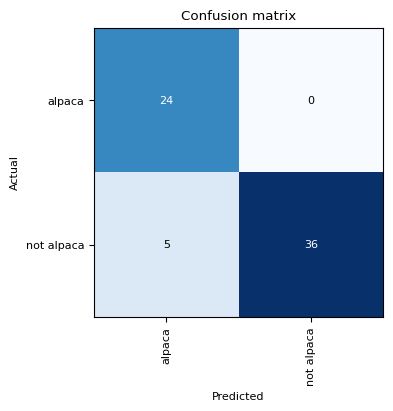

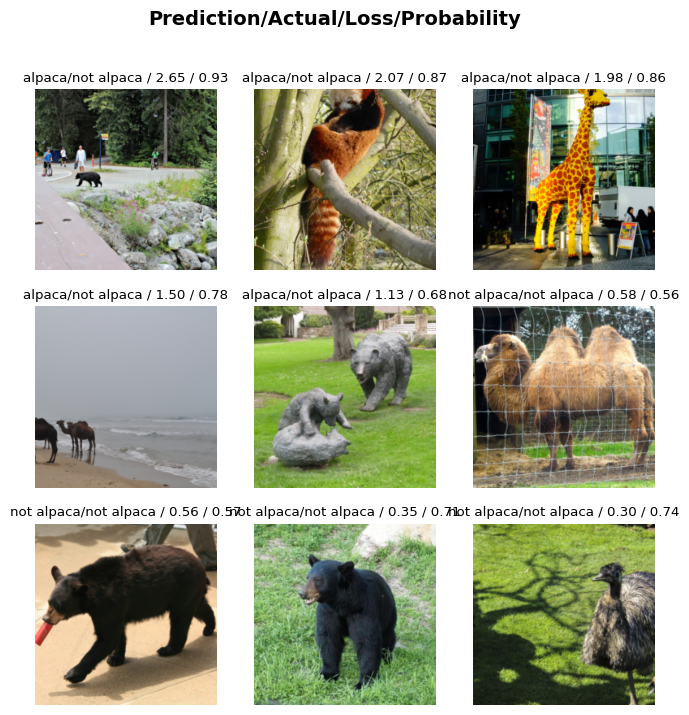

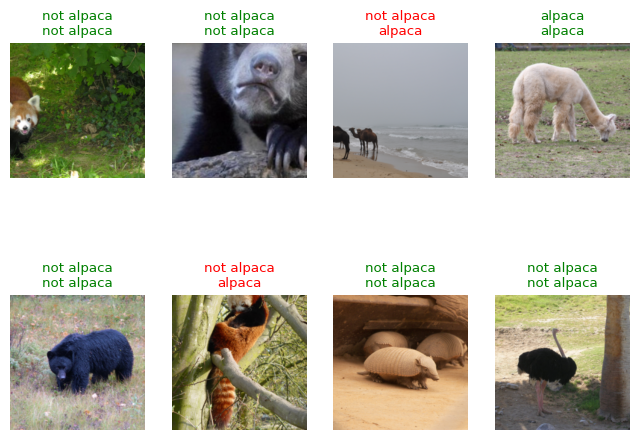

In [72]:
interp_base = ClassificationInterpretation.from_learner(learn_base)
interp_base.plot_confusion_matrix(figsize=(4,4))
interp_base.plot_top_losses(9, figsize=(8,8))
learn_base.show_results(max_n=8, figsize=(8,6))


Baseline Model (ResNet34)

We trained a ResNet34 model using transfer learning for 3 epochs with a base learning rate of 3e-3.

The model achieved a validation accuracy of 93.85%, indicating strong baseline performance on this binary classification task.

- Final train_loss: 0.1308
- Final valid_loss: 0.1866
- Validation accuracy: 92.31%

The confusion matrix shows that the model correctly classified all alpaca images in the validation set, achieving a recall of 100% for the alpaca class.

However, 5 images from the "not alpaca" class were incorrectly classified as alpaca. This suggests that while the model is very sensitive to detecting alpacas, it may sometimes confuse visually similar animals (e.g., llamas or goats) with alpacas.

By inspecting the top losses and incorrect predictions, we observe that most misclassifications occur in images where animals share similar visual features such as fur texture, face structure, or background context. This indicates that the model relies heavily on high-level visual cues rather than fine-grained distinguishing features.



## Improvement 1 — Data Augmentation (ResNet34)

We apply lightweight geometric transformations to increase robustness
to variations in pose and orientation.


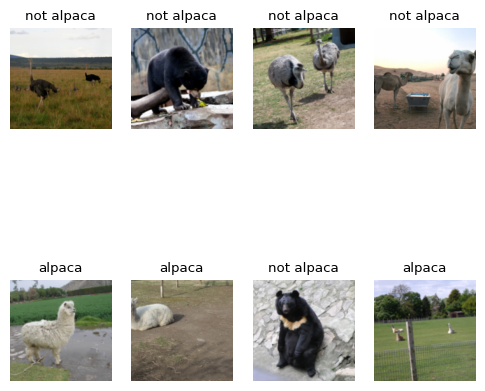

In [73]:
dls_aug = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(160),
    batch_tfms=[FlipItem(), Rotate(max_deg=10)],
    bs=8
)


dls_aug.show_batch(max_n=9, figsize=(6,6))


Training with Augmentation

The model is trained for two epochs due to the higher computational cost of augmentation.


In [74]:
learn_aug = vision_learner(dls_aug, resnet34, metrics=accuracy)
learn_aug.fine_tune(3, base_lr=5e-4)


Augmentation Results



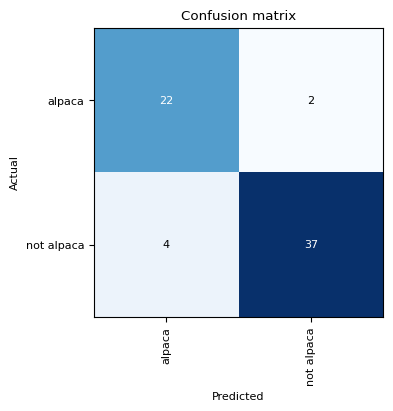

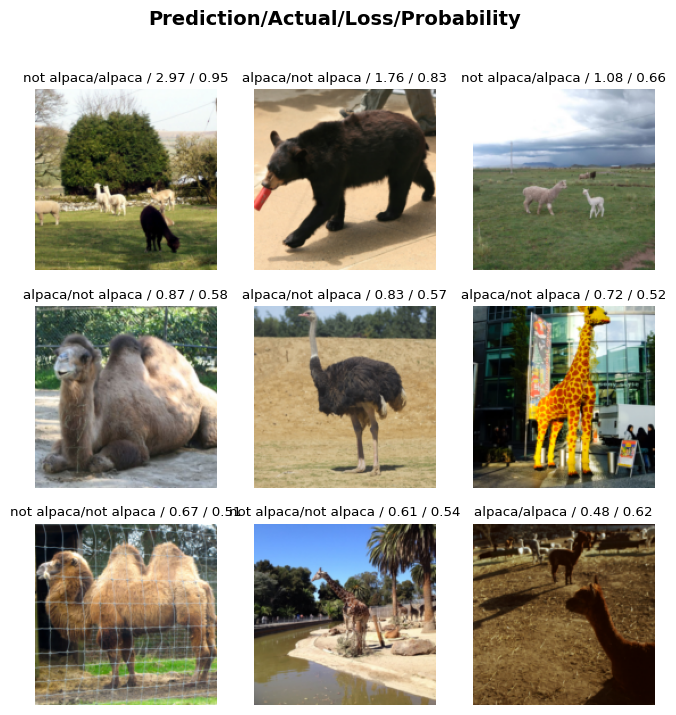

In [75]:
interp_aug = ClassificationInterpretation.from_learner(learn_aug)
interp_aug.plot_confusion_matrix(figsize=(4,4))
interp_aug.plot_top_losses(9, figsize=(8,8))


The augmented model achieved a validation accuracy of 90.7%, which is lower than the baseline model.

This decrease in performance can be explained by several factors:
- The model was trained for fewer epochs compared to the baseline.
- The baseline model already achieved very high accuracy, leaving little room for improvement.
- Data augmentation may distort fine-grained visual features that are important for distinguishing alpacas from visually similar animals.

The confusion matrix shows an increase in both false negatives and false positives compared to the baseline model. In particular, some alpaca images were misclassified as not alpaca, indicating reduced sensitivity to the target class.

While data augmentation is commonly used to improve generalization, in this specific task it did not improve validation accuracy. This highlights the importance of tailoring augmentation strategies to the problem and dataset characteristics.

## Improvement 2 – Deeper Backbone (ResNet50)

We evaluate whether increased model capacity improves performance.


Train ResNet50

To evaluate whether a deeper architecture improves performance, we trained a ResNet50 model using the same data split and training setup as the baseline model.


In [76]:
learn_r50 = vision_learner(dls_base, resnet50, metrics=accuracy)
learn_r50.fine_tune(3, base_lr=3e-3)


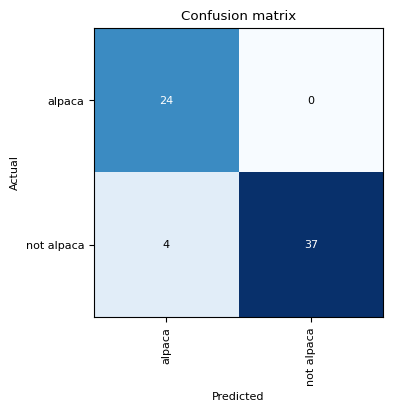

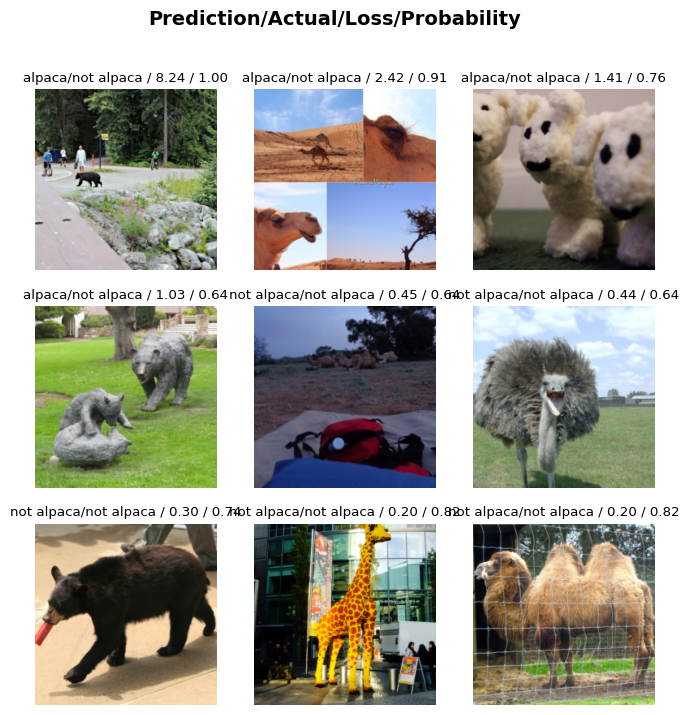

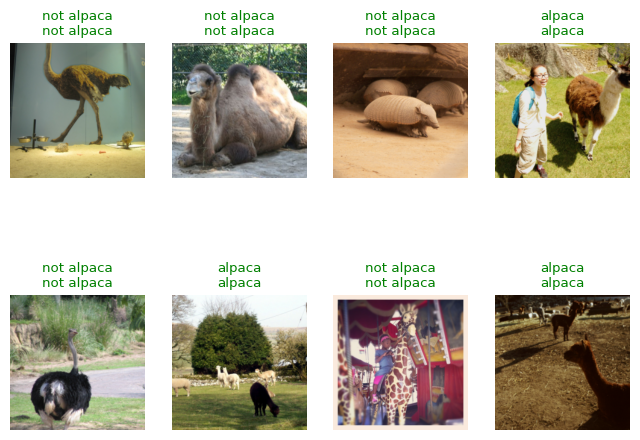

In [77]:
interp_r50 = ClassificationInterpretation.from_learner(learn_r50)
interp_r50.plot_confusion_matrix(figsize=(4,4))
interp_r50.plot_top_losses(9, figsize=(8,8))
learn_r50.show_results(max_n=8, figsize=(8,6))



The ResNet50 model achieved a validation accuracy of 93.8%, slightly outperforming the baseline ResNet34 model.

This modest improvement can be explained by several factors:
- ResNet50 is a deeper and more expressive architecture, which can capture more complex visual patterns.
- All models were trained under the same training budget (3 epochs), enabling a fair comparison.
- Despite the increased capacity, the simplicity of the binary classification task limited the potential performance gains.

The confusion matrix shows perfect recall for the alpaca class, similar to the baseline model, indicating that all alpaca images were correctly identified. In addition, ResNet50 resulted in a slightly lower number of false positives compared to the baseline, suggesting a marginal improvement in precision.

Overall, while the deeper architecture provided a small performance gain, the improvement was limited. This suggests that for small and relatively simple datasets, increasing model complexity may lead to diminishing returns, and lighter architectures can achieve comparable performance with lower computational cost.


## Results

After training all models for the same number of epochs (3), the ResNet50 model achieved the highest validation accuracy of **93.8%**, slightly outperforming the baseline ResNet34 model (**92.31%**) and the augmented ResNet34 model (**90.76%**).

While ResNet50 is a deeper and more expressive architecture, the improvement over the baseline model is relatively modest. Both ResNet34 (baseline) and ResNet50 achieved perfect recall for the alpaca class, indicating that all alpaca images in the validation set were correctly identified.

The ResNet50 model resulted in slightly fewer false positives compared to the baseline ResNet34 model. However, this reduction was marginal and did not lead to a substantial improvement in overall performance.

Both ResNet34 and ResNet50 achieved perfect recall for the alpaca class. ResNet50 showed a small reduction in false positives compared to the baseline, but the difference was minor, suggesting that the deeper architecture did not provide a significant advantage for this task.

Overall, these results demonstrate that increasing model complexity does not necessarily lead to substantial gains in performance, especially on small and relatively simple datasets. In such settings, lighter models such as ResNet34 can achieve competitive—and sometimes more stable—performance while requiring fewer parameters and less computational cost.


| Model                | Epochs | Accuracy | Alpaca Recall | 
|----------------------|--------|----------|---------------|
| ResNet34 (Baseline)  | 3      | 92.31%   | 100%          | 
| ResNet34 + Augment   | 3      | 90.76%   | 91.7%         | 
| ResNet50             | 3      | 93.8%    | 100%          | 
